## Parsing of an EggNOG annotation file and construction of a draft COBRA model

# Libraries

In [17]:
import requests
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import cobra
from cobra import Model, Reaction, Metabolite
import networkx as nx
import os

# Parse and organize ModelSeed Files

Note: in writing this code, I realized that ModelSeed has many duplicates, i.e. multiple reactions stoichiometrically identical, and with the same EC number. In the script below, I asked to remove this redundancy.

In [3]:
# Don't need to run this since I already downloaded the databases
# -----------------------------------------------------------------------------
# 1. Download ModelSEED Data Files
# -----------------------------------------------------------------------------

# compounds_url = "https://raw.githubusercontent.com/ModelSEED/ModelSEEDDatabase/master/Biochemistry/compounds.json"
# reactions_url = "https://raw.githubusercontent.com/ModelSEED/ModelSEEDDatabase/master/Biochemistry/reactions.json"

# print("Downloading ModelSEED compounds...")
# compounds_data = requests.get(compounds_url).json()
# total_compounds = len(compounds_data)
# print(f"Downloaded {total_compounds} compounds.")

# print("Downloading ModelSEED reactions...")
# reactions_data = requests.get(reactions_url).json()
# total_reactions = len(reactions_data)
# print(f"Downloaded {total_reactions} reactions.")

Downloaded 33992 compounds.
Downloaded 43774 reactions.

Reactions with status 'OK': 32014 (out of 43774 downloaded)


In [6]:
# Instead, load the data from the files
compounds_data = json.load(open("/Users/helenscott/Documents/PhD/Segre-lab/ModelSEEDDatabase/Biochemistry/compounds.json"))
total_compounds = len(compounds_data)
print(f"Loaded {total_compounds} compounds.")

reactions_data = json.load(open("/Users/helenscott/Documents/PhD/Segre-lab/ModelSEEDDatabase/Biochemistry/reactions.json"))
total_reactions = len(reactions_data)
print(f"Loaded {total_reactions} reactions.")

Loaded 33992 compounds.
Loaded 43774 reactions.


In [7]:
# -----------------------------------------------------------------------------
# 2. Filter and Organize the Data (keep only reactions with status "OK")
# -----------------------------------------------------------------------------

# Build a dictionary of compounds keyed by compound id.
compounds_by_id = { compound["id"]: compound for compound in compounds_data if "id" in compound }

# Filter reactions: keep only those with status "OK"
ok_reactions = [rxn for rxn in reactions_data if rxn.get("status", "").strip().upper() == "OK"]
num_ok_reactions = len(ok_reactions)
print(f"\nReactions with status 'OK': {num_ok_reactions} (out of {total_reactions} downloaded)")


Reactions with status 'OK': 32014 (out of 43774 downloaded)


In [8]:
ok_reactions

[{'abbreviation': 'R00004',
  'abstract_reaction': None,
  'aliases': ['AraCyc: INORGPYROPHOSPHAT-RXN',
   'BiGG: IPP1; PPA; PPA_1; PPAm',
   'BrachyCyc: INORGPYROPHOSPHAT-RXN',
   'KEGG: R00004',
   'MetaCyc: INORGPYROPHOSPHAT-RXN',
   'Name: Diphosphate phosphohydrolase; Inorganic diphosphatase; Inorganic pyrophosphatase; Pyrophosphate phosphohydrolase; diphosphate phosphohydrolase; inorganic diphosphatase; inorganic diphosphatase (one proton translocation); inorganicdiphosphatase; pyrophosphate phosphohydrolase'],
  'code': '(1) cpd00001[0] + (1) cpd00012[0] <=> (2) cpd00009[0]',
  'compound_ids': 'cpd00001;cpd00009;cpd00012;cpd00067',
  'definition': '(1) H2O[0] + (1) PPi[0] <=> (2) Phosphate[0] + (1) H+[0]',
  'deltag': -3.46,
  'deltagerr': 0.05,
  'direction': '=',
  'ec_numbers': ['3.6.1.1'],
  'equation': '(1) cpd00001[0] + (1) cpd00012[0] <=> (2) cpd00009[0] + (1) cpd00067[0]',
  'id': 'rxn00001',
  'is_obsolete': 0,
  'is_transport': 0,
  'linked_reaction': 'rxn27946;rxn2794

In [10]:
# Extract KEGG Reaction ID from aliases.
for rxn in ok_reactions:
    aliases = rxn.get("aliases")
    kegg_rxn = None
    if aliases and isinstance(aliases, list):
        for alias in aliases:
            alias_lower = alias.lower()
            if alias_lower.startswith("kegg:"):
                kegg_rxn = alias.split(":", 1)[1].strip()
                break
            elif alias_lower.startswith("kegg_"):
                kegg_rxn = alias.split("_", 1)[1].strip()
                break
    rxn["kegg_reaction"] = kegg_rxn  # This seems unnecessary, this information is already in the aliases, why not just use that?

In [11]:
ok_reactions[0]

{'abbreviation': 'R00004',
 'abstract_reaction': None,
 'aliases': ['AraCyc: INORGPYROPHOSPHAT-RXN',
  'BiGG: IPP1; PPA; PPA_1; PPAm',
  'BrachyCyc: INORGPYROPHOSPHAT-RXN',
  'KEGG: R00004',
  'MetaCyc: INORGPYROPHOSPHAT-RXN',
  'Name: Diphosphate phosphohydrolase; Inorganic diphosphatase; Inorganic pyrophosphatase; Pyrophosphate phosphohydrolase; diphosphate phosphohydrolase; inorganic diphosphatase; inorganic diphosphatase (one proton translocation); inorganicdiphosphatase; pyrophosphate phosphohydrolase'],
 'code': '(1) cpd00001[0] + (1) cpd00012[0] <=> (2) cpd00009[0]',
 'compound_ids': 'cpd00001;cpd00009;cpd00012;cpd00067',
 'definition': '(1) H2O[0] + (1) PPi[0] <=> (2) Phosphate[0] + (1) H+[0]',
 'deltag': -3.46,
 'deltagerr': 0.05,
 'direction': '=',
 'ec_numbers': ['3.6.1.1'],
 'equation': '(1) cpd00001[0] + (1) cpd00012[0] <=> (2) cpd00009[0] + (1) cpd00067[0]',
 'id': 'rxn00001',
 'is_obsolete': 0,
 'is_transport': 0,
 'linked_reaction': 'rxn27946;rxn27947;rxn27948;rxn32487;

In [14]:
# Deduplicate reactions by KEGG Reaction ID.
kegg_to_rxn = {}
def get_rxn_number(rxn_id):
    m = re.search(r'\d+', rxn_id)
    return int(m.group(0)) if m else float('inf')

for rxn in ok_reactions:
    kegg_id = rxn.get("kegg_reaction")
    if not kegg_id:
        continue
    kegg_id = kegg_id.strip().upper()
    if kegg_id not in kegg_to_rxn:
        kegg_to_rxn[kegg_id] = {}
    eq = rxn.get("equation", "").strip()
    if not eq:
        continue
    if eq not in kegg_to_rxn[kegg_id]:
        kegg_to_rxn[kegg_id][eq] = rxn  # Why are we storing it with the equation as the key?
    else:
        existing_rxn = kegg_to_rxn[kegg_id][eq]
        existing_id = existing_rxn.get("id", "")
        new_id = rxn.get("id", "")
        if get_rxn_number(new_id) < get_rxn_number(existing_id):
            kegg_to_rxn[kegg_id][eq] = rxn  # Overwrites the existing reaction with the new one if the new one has a lower reaction number


In [15]:
len(kegg_to_rxn)

7673

# Parse EggNOG file and add fields (metabolism/transport/none and ModelSeed RXN ID)

In [20]:
# -------------------------------
# 1. Define the EggNOG file header and read the file
# -------------------------------
df = pd.read_csv(
    os.path.join("genome", "eggnog_output.emapper.annotations"),
    sep="\t",
    comment="#",
)
df.columns = [
    "query",
    "seed_ortholog",
    "evalue",
    "score",
    "eggNOG_OGs",
    "max_annot_lvl",
    "COG_category",
    "Description",
    "Preferred_name",
    "GOs",
    "EC",
    "KEGG_ko",
    "KEGG_Pathway",
    "KEGG_Module",
    "KEGG_Reaction",
    "KEGG_rclass",
    "BRITE",
    "KEGG_TC",
    "CAZy",
    "BiGG_Reaction",
    "PFAMs",
]
df

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
0,1,1004785.AMBLS11_00010,1.330000e-254,699.0,"COG0592@1|root,COG0592@2|Bacteria,1MVD9@1224|P...",1236|Gammaproteobacteria,L,Confers DNA tethering and processivity to DNA ...,dnaN,"GO:0003674,GO:0003824,GO:0003887,GO:0005488,GO...",...,ko:K02338,"ko00230,ko00240,ko01100,ko03030,ko03430,ko0344...",M00260,"R00375,R00376,R00377,R00378",RC02795,"ko00000,ko00001,ko00002,ko01000,ko03032,ko03400",-,-,-,"DNA_pol3_beta,DNA_pol3_beta_2,DNA_pol3_beta_3"
1,2,1004785.AMBLS11_00015,9.750000e-255,699.0,"COG1195@1|root,COG1195@2|Bacteria,1MX8N@1224|P...",1236|Gammaproteobacteria,L,it is required for DNA replication and normal ...,recF,"GO:0000731,GO:0003674,GO:0003676,GO:0003677,GO...",...,ko:K03629,"ko03440,map03440",-,-,-,"ko00000,ko00001,ko03400",-,-,-,SMC_N
2,3,1004785.AMBLS11_00020,0.000000e+00,1576.0,"COG0187@1|root,COG0187@2|Bacteria,1MVKT@1224|P...",1236|Gammaproteobacteria,L,A type II topoisomerase that negatively superc...,gyrB,"GO:0000166,GO:0003674,GO:0003676,GO:0003677,GO...",...,ko:K02470,-,-,-,-,"ko00000,ko01000,ko03032,ko03400",-,-,-,"DNA_gyraseB,DNA_gyraseB_C,HATPase_c,Toprim"
3,4,1004785.AMBLS11_00025,1.520000e-101,294.0,"2DZJ0@1|root,33638@2|Bacteria,1N9JU@1224|Prote...",1236|Gammaproteobacteria,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,5,1004785.AMBLS11_00030,0.000000e+00,1285.0,"COG0751@1|root,COG0751@2|Bacteria,1MV2F@1224|P...",1236|Gammaproteobacteria,J,Glycyl-tRNA synthetase beta subunit,glyS,"GO:0003674,GO:0003824,GO:0004812,GO:0004820,GO...",...,ko:K01879,"ko00970,map00970",M00360,R03654,"RC00055,RC00523","ko00000,ko00001,ko00002,ko01000,ko01007,ko03016",-,-,"iAPECO1_1312.APECO1_2891,iE2348C_1286.E2348C_3...","DALR_1,tRNA_synt_2f"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,4095,927677.ALVU02000001_gene1424,3.080000e-04,47.0,"COG2204@1|root,COG4191@1|root,COG5000@1|root,C...",1117|Cyanobacteria,T,Histidine kinase-like ATPases,-,-,...,-,-,-,-,-,-,-,-,-,"HATPase_c,HisKA,PAS,PAS_3,PAS_9,Response_reg"
3924,4097,1195246.AGRI_12766,1.380000e-41,154.0,"COG0784@1|root,COG0784@2|Bacteria,1MZVE@1224|P...",1236|Gammaproteobacteria,T,COG0784 FOG CheY-like receiver,-,-,...,ko:K03413,"ko02020,ko02030,map02020,map02030",M00506,-,-,"ko00000,ko00001,ko00002,ko02022,ko02035",-,-,-,Response_reg
3925,4098,1123020.AUIE01000007_gene3262,1.830000e-24,98.2,"298T8@1|root,2ZVXH@2|Bacteria,1P89S@1224|Prote...",1236|Gammaproteobacteria,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3926,4100,1117318.PRUB_08340,1.430000e-100,299.0,"COG2356@1|root,COG2356@2|Bacteria,1RI3H@1224|P...",1236|Gammaproteobacteria,L,Protein of unknown function (DUF1524),-,-,...,-,-,-,-,-,-,-,-,-,DUF1524


In [22]:
# -------------------------------
# 2. (Optional) Organize EggNOG Data by Gene
# -------------------------------
# (We keep all entries in the DataFrame; later we add new fields per record.)
# Ensure that missing Preferred_name values are retained (as empty strings).
df["Preferred_name"] = df["Preferred_name"].fillna("").astype(str).str.strip()


In [ ]:
# -------------------------------
# 3. Helper Functions
# -------------------------------
def classify_gene(description):
    """
    Infers the putative role of a gene based solely on its description.
    Returns:
      - "transporter" if the description contains transporter-related keywords,
      - "metabolic" if the description contains metabolic enzyme keywords (and no transporter-related keyword),
      - "none" otherwise.
    """
    if pd.isna(description):
        return "none"
    desc = str(description).lower()

    transporter_keywords = [
        "transport", "transporter", "pump", "channel", "permease", "symporter",
        "antiporter", "exchanger", "carrier", "facilitated", "translocase",
        "influx", "efflux", "import", "export"
    ]
    metabolic_keywords = [
        "dehydrogenase", "kinase", "synthase", "reductase", "transferase", "lyase",
        "isomerase", "hydrolase", "oxidoreductase", "ligase", "carboxylase",
        "aminotransferase", "phosphatase", "enzyme", "biosynthesis", "metabolism"
    ]

    if any(kw in desc for kw in transporter_keywords):
        return "transporter"
    if any(kw in desc for kw in metabolic_keywords):
        return "metabolic"
    return "none"

def get_modelseed_rxns(kegg_rxn_field, mapping):
    """
    Given a KEGG_Reaction field from EggNOG (which may contain multiple comma-separated KEGG IDs),
    look up each KEGG ID in the provided mapping (kegg_to_rxn) and return a comma-separated string
    of ModelSEED reaction IDs.
    'mapping' should be a dictionary where keys are KEGG reaction IDs (uppercase)
    and values are dictionaries mapping unique reaction equations to ModelSEED reaction dicts.
    If no mapping is found for a given KEGG ID, that KEGG ID is skipped.
    """
    if pd.isna(kegg_rxn_field):
        return ""
    kegg_rxn_field = str(kegg_rxn_field).strip()
    if kegg_rxn_field in {"", "-"}:
        return ""
    modelseed_ids = set()
    # Split the KEGG reaction field by commas (if multiple)
    for kegg in kegg_rxn_field.split(","):
        kegg = kegg.strip().upper()
        if kegg in mapping:
            # mapping[kegg] is a dictionary keyed by reaction equation; take all reaction IDs.
            for eq, rxn in mapping[kegg].items():
                rxn_id = rxn.get("id", "")
                if rxn_id:
                    modelseed_ids.add(rxn_id)
    return ", ".join(sorted(modelseed_ids))

In [ ]:
# -------------------------------
# 4. Build the ModelSeed mapping (kegg_to_rxn) from your ModelSEED parsing
# -------------------------------
# (This part is assumed to be already executed; below is the provided ModelSEED parser snippet.)

# --- Download ModelSEED data (if not already done) ---
# compounds_url = "https://raw.githubusercontent.com/ModelSEED/ModelSEEDDatabase/master/Biochemistry/compounds.json"
# reactions_url = "https://raw.githubusercontent.com/ModelSEED/ModelSEEDDatabase/master/Biochemistry/reactions.json"

# compounds_data = requests.get(compounds_url).json()
# reactions_data = requests.get(reactions_url).json()

# # Filter reactions: keep only those with status "OK"
# ok_reactions = [rxn for rxn in reactions_data if rxn.get("status", "").strip().upper() == "OK"]

# # Extract KEGG Reaction ID from aliases.
# for rxn in ok_reactions:
#     aliases = rxn.get("aliases")
#     kegg_rxn = None
#     if aliases and isinstance(aliases, list):
#         for alias in aliases:
#             alias_lower = alias.lower()
#             if alias_lower.startswith("kegg:"):
#                 kegg_rxn = alias.split(":", 1)[1].strip()
#                 break
#             elif alias_lower.startswith("kegg_"):
#                 kegg_rxn = alias.split("_", 1)[1].strip()
#                 break
#     rxn["kegg_reaction"] = kegg_rxn

# # Deduplicate reactions by KEGG Reaction ID.
# kegg_to_rxn = {}
# def get_rxn_number(rxn_id):
#     m = re.search(r'\d+', rxn_id)
#     return int(m.group(0)) if m else float('inf')

# for rxn in ok_reactions:
#     kegg_id = rxn.get("kegg_reaction")
#     if not kegg_id:
#         continue
#     kegg_id = kegg_id.strip().upper()
#     if kegg_id not in kegg_to_rxn:
#         kegg_to_rxn[kegg_id] = {}
#     eq = rxn.get("equation", "").strip()
#     if not eq:
#         continue
#     if eq not in kegg_to_rxn[kegg_id]:
#         kegg_to_rxn[kegg_id][eq] = rxn
#     else:
#         existing_rxn = kegg_to_rxn[kegg_id][eq]
#         existing_id = existing_rxn.get("id", "")
#         new_id = rxn.get("id", "")
#         if get_rxn_number(new_id) < get_rxn_number(existing_id):
#             kegg_to_rxn[kegg_id][eq] = rxn

In [ ]:
# -------------------------------
# 5. Add New Fields to the EggNOG DataFrame
# -------------------------------
# a) ModelSeed_Reaction_IDs: based on KEGG_Reaction field and the mapping (kegg_to_rxn)
# b) Gene_Type: classify based on Description
df["ModelSeed_Reaction_IDs"] = df["KEGG_Reaction"].apply(lambda x: get_modelseed_rxns(x, kegg_to_rxn))
df["Gene_Type"] = df["Description"].apply(classify_gene)

In [ ]:
# -------------------------------
# 6. Export the DataFrame to Excel
# -------------------------------
excel_filename = "EggNOG_with_ModelSeed_and_GeneType.xlsx"
with pd.ExcelWriter(excel_filename, engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="EggNOG_Annotations", index=False)

print(f"Exported EggNOG annotations with added ModelSeed and Gene_Type fields to '{excel_filename}'.")

In [ ]:
# -------------------------------
# 7. Examples of Access
# -------------------------------
# Access records by gene (e.g., gene "dnaA")
gene_query = "dnaA"
if gene_query in df["Preferred_name"].str.lower().values:
    print(f"\nRecords for gene {gene_query}:")
    print(df[df["Preferred_name"].str.lower() == gene_query.lower()].to_string(index=False))
else:
    print(f"\nGene {gene_query} not found.")

# Access annotations by KEGG Reaction.
kegg_index = {}
for idx, rec in df.iterrows():
    kegg_field = rec.get("KEGG_Reaction", "")
    if pd.notna(kegg_field) and kegg_field.strip() not in {"", "-"}:
        for kegg in kegg_field.split(","):
            kegg = kegg.strip().upper()
            if kegg:
                kegg_index.setdefault(kegg, []).append(rec)

target_kegg = "R00001"
if target_kegg in kegg_index:
    print(f"\nAnnotations for KEGG Reaction {target_kegg}:")
    for rec in kegg_index[target_kegg]:
        print(rec)
else:
    print(f"\nKEGG Reaction {target_kegg} not found in annotations.")


In [8]:
df

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,ModelSeed_Reaction_IDs,Gene_Type
0,## emapper-2.1.12-508fa4b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,none
1,## /projectnb/cometsfba/hscott/envs/eggnog/bin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,none
2,##,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,none
4,0,1004785.AMBLS11_00005,0.0,891.0,"COG0593@1|root,COG0593@2|Bacteria,1MU5H@1224|P...",1236|Gammaproteobacteria,L,it binds specifically double-stranded DNA at a...,dnaA,"GO:0000166,GO:0003674,GO:0003676,GO:0003677,GO...",...,-,-,-,"ko00000,ko00001,ko03032,ko03036",-,-,-,"Bac_DnaA,Bac_DnaA_C,DnaA_N",,none
5,1,1004785.AMBLS11_00010,1.33e-254,699.0,"COG0592@1|root,COG0592@2|Bacteria,1MVD9@1224|P...",1236|Gammaproteobacteria,L,Confers DNA tethering and processivity to DNA ...,dnaN,"GO:0003674,GO:0003824,GO:0003887,GO:0005488,GO...",...,M00260,"R00375,R00376,R00377,R00378",RC02795,"ko00000,ko00001,ko00002,ko01000,ko03032,ko03400",-,-,-,"DNA_pol3_beta,DNA_pol3_beta_2,DNA_pol3_beta_3",,metabolic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,4100,1117318.PRUB_08340,1.43e-100,299.0,"COG2356@1|root,COG2356@2|Bacteria,1RI3H@1224|P...",1236|Gammaproteobacteria,L,Protein of unknown function (DUF1524),-,-,...,-,-,-,-,-,-,-,DUF1524,,none
3932,4101,1121935.AQXX01000108_gene410,1.17e-09,64.3,"COG3916@1|root,COG3916@2|Bacteria",2|Bacteria,QT,Acyl-homoserine-lactone synthase,-,-,...,-,-,-,-,-,-,-,Acetyltransf_5,,metabolic
3933,## 3929 queries scanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,none
3934,## Total time (seconds): 9044.003806352615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,none


# Create Genome scale model from KEGG reaction IDs identified in EggNOG and matched in ModelSeed

In [ ]:
import cobra
from cobra import Model, Reaction, Metabolite
import pandas as pd
import re
from collections import defaultdict

# -----------------------------------------------------------------------------
# 1. Load the EggNOG file (with added 'ModelSeed_Reaction_IDs') into a DataFrame
# -----------------------------------------------------------------------------
egg_filename = "EggNOG_with_ModelSeed_and_GeneType.xlsx"
df_augmented = pd.read_excel(egg_filename, sheet_name="EggNOG_Annotations")
print(f"Loaded EggNOG augmented file with {len(df_augmented)} rows.")

# -----------------------------------------------------------------------------
# 2. Load / parse your ModelSEED data (the 'ok_reactions' or dictionary keyed by reaction 'id')
# -----------------------------------------------------------------------------
# We assume you already have 'ok_reactions' (a list of reaction dicts with status="OK").
# Build a dictionary keyed by reaction ID.
ok_reactions_dict = { rxn["id"]: rxn for rxn in ok_reactions if "id" in rxn }

# Helper to parse stoichiometry from the ModelSEED "stoichiometry" field.
def parse_stoich_field(stoich_str):
    """
    A stoichiometry string has multiple items separated by ';'.
    Each item is:  n:cpdid:m:i:"cpdname"
      - n = coefficient (negative=reactant, positive=product)
      - cpdid = compound ID, e.g. "cpd00001"
      - m = compartment index (0 -> c, 1 -> e, etc.)
      - i = community index (often 0, ignore)
      - "cpdname" = compound name in quotes
    Returns a dictionary mapping 'met_id_with_compartment' to coefficient.
    """
    if not isinstance(stoich_str, str) or not stoich_str.strip():
        return {}
    stoich_dict = {}
    tokens = stoich_str.split(";")
    for t in tokens:
        t = t.strip()
        if not t:
            continue
        parts = t.split(":")
        if len(parts) < 5:
            continue
        try:
            coeff = float(parts[0])
            cpd_id = parts[1].strip()
            comp_idx = parts[2].strip()
        except ValueError:
            continue

        # Convert comp_idx into a compartment code.
        if comp_idx == "0":
            compartment = "c"
        elif comp_idx == "1":
            compartment = "e"
        else:
            compartment = "c"  # default if unknown

        full_met_id = f"{cpd_id}_{compartment}"
        # Sum coefficients if duplicates appear.
        stoich_dict[full_met_id] = stoich_dict.get(full_met_id, 0) + coeff
    return stoich_dict

def set_reaction_bounds_from_direction(reaction, direction):
    """
    direction can be one of:
      - '>' => forward only => [0, 1000]
      - '<' => reverse only => [-1000, 0]
      - '=' => bidirectional => [-1000, 1000]
      - or unknown => default to bidirectional
    """
    direction = direction.strip() if isinstance(direction, str) else "="
    if direction == ">":
        reaction.lower_bound = 0
        reaction.upper_bound = 1000
    elif direction == "<":
        reaction.lower_bound = -1000
        reaction.upper_bound = 0
    else:
        # '=' or anything else => reversible
        reaction.lower_bound = -1000
        reaction.upper_bound = 1000

# -----------------------------------------------------------------------------
# 3. Create a COBRA model
# -----------------------------------------------------------------------------
model = Model("model_from_eggnog_and_modelseed")
print("Creating a new COBRA model...")

# We'll track Reaction objects in a dictionary keyed by ModelSEED reaction ID,
# so we can update them if we find more genes later.
rxnid_to_reaction = {}

# We'll also track a set of genes for each reaction, so we can build a gene_reaction_rule at the end.
rxnid_to_genes = defaultdict(set)

# -----------------------------------------------------------------------------
# 4. Iterate over each EggNOG entry, find all ModelSeed Reaction IDs, add them
# -----------------------------------------------------------------------------
for idx, row in df_augmented.iterrows():
    ms_rxn_ids_str = row.get("ModelSeed_Reaction_IDs", "")
    if pd.isna(ms_rxn_ids_str) or not ms_rxn_ids_str.strip():
        continue
    ms_rxn_ids = [r.strip() for r in ms_rxn_ids_str.split(",") if r.strip()]

    # Gather the gene name (if present).
    gene_name = row.get("Preferred_name", "")
    gene_name = str(gene_name).strip()

    for rxn_id in ms_rxn_ids:
        if rxn_id not in ok_reactions_dict:
            continue  # not found in ModelSEED
        ms_rxn = ok_reactions_dict[rxn_id]

        # If we haven't built this reaction yet, create it now.
        if rxn_id not in rxnid_to_reaction:
            # Parse stoichiometry from "stoichiometry" field
            stoich_str = ms_rxn.get("stoichiometry", "")
            stoich_dict = parse_stoich_field(stoich_str)

            reaction = Reaction(rxn_id)
            reaction.name = ms_rxn.get("name", rxn_id)

            # Set bounds based on direction
            direction = ms_rxn.get("direction", "=")
            set_reaction_bounds_from_direction(reaction, direction)

            # Add the reaction to the model
            model.add_reactions([reaction])

            # Create or retrieve each metabolite
            new_stoich = {}
            for met_full_id, coeff in stoich_dict.items():
                if "_" in met_full_id:
                    base_id, comp = met_full_id.rsplit("_", 1)
                else:
                    base_id, comp = met_full_id, "c"
                try:
                    met_obj = model.metabolites.get_by_id(met_full_id)
                except KeyError:
                    # Could look up compound name from compounds_data, if desired
                    met_obj = Metabolite(met_full_id, formula="", name=base_id, compartment=comp)
                    model.add_metabolites([met_obj])
                new_stoich[met_obj] = coeff

            # Add stoichiometry to reaction
            reaction.add_metabolites(new_stoich)

            rxnid_to_reaction[rxn_id] = reaction

        # Now, add the gene name (if any) to this reaction's gene set
        if gene_name and gene_name != "-":
            rxnid_to_genes[rxn_id].add(gene_name)

# -----------------------------------------------------------------------------
# 5. Build gene_reaction_rule from collected genes
# -----------------------------------------------------------------------------
for rxn_id, rxn_obj in rxnid_to_reaction.items():
    # Convert the gene set to a rule
    geneset = rxnid_to_genes[rxn_id]
    if geneset:
        # e.g. join by " or "
        rule = " or ".join(sorted(geneset))
        rxn_obj.gene_reaction_rule = rule

# -----------------------------------------------------------------------------
# 6. Summarize the model
# -----------------------------------------------------------------------------
print(f"\nCOBRA model built from EggNOG+ModelSEED data:")
print(f"Number of reactions in model: {len(model.reactions)}")
print(f"Number of metabolites in model: {len(model.metabolites)}")
print(f"Number of genes in model: {len(model.genes)}")

# For demonstration, print sample reactions
for rxn in list(model.reactions)[:10]:
    print(f"{rxn.id}: {rxn.reaction}  (Bounds: [{rxn.lower_bound}, {rxn.upper_bound}])")
    print(f" Gene Reaction Rule: {rxn.gene_reaction_rule}")

# Optionally, save the model
cobra.io.save_json_model(model, "model_from_eggnog_modelseed_with_genes.json")
print("Model saved to 'model_from_eggnog_modelseed_with_genes.json'.")


Loaded EggNOG augmented file with 3935 rows.
Creating a new COBRA model...

COBRA model built from EggNOG+ModelSEED data:
Number of reactions in model: 1329
Number of metabolites in model: 1161
Number of genes in model: 565
rxn06538: cpd00201_c + cpd12105_c --> cpd00067_c + cpd00087_c + cpd12285_c  (Bounds: [0, 1000])
 Gene Reaction Rule: fmt
rxn40257: cpd00002_c + cpd00161_c + cpd00242_c <=> cpd00001_c + cpd00012_c + cpd00067_c + cpd31250_c  (Bounds: [-1000, 1000])
 Gene Reaction Rule: tsaC
rxn02303: cpd00007_c + 2.0 cpd00067_c + cpd02083_c --> 2.0 cpd00001_c + 2.0 cpd00011_c + cpd00791_c  (Bounds: [0, 1000])
 Gene Reaction Rule: hemF
rxn01740: cpd00006_c + cpd00383_c <=> cpd00005_c + cpd00067_c + cpd01716_c  (Bounds: [-1000, 1000])
 Gene Reaction Rule: aroE
rxn02341: cpd00067_c + cpd02666_c --> cpd00011_c + cpd00834_c  (Bounds: [0, 1000])
 Gene Reaction Rule: coaBC
rxn09177: cpd00052_c + cpd00084_c + cpd02201_c --> cpd00012_c + cpd00046_c + 2.0 cpd00067_c + cpd02666_c  (Bounds: [0, 1

In [ ]:
import re

# Assume compounds_data is a list of compound dicts loaded from ModelSEED "compounds.json"
# and ok_reactions is a list of reaction dicts loaded from ModelSEED "reactions.json"
# filtered to status == "OK".

# Build a dictionary of compounds keyed by compound id, for quick lookup of names.
compounds_by_id = {}
for cpd in compounds_data:
    if "id" in cpd:
        compounds_by_id[cpd["id"]] = cpd

# We define a function to parse the stoichiometry field of a reaction (ModelSEED format).
def parse_stoich(stoich_str):
    """
    Parse the ModelSEED stoichiometry field:
    e.g. '-1:cpd00001:0:0:"H2O";2:cpd00067:0:0:"H+"'
    Returns a dict: { compound_id: coefficient }
    """
    if not isinstance(stoich_str, str) or not stoich_str.strip():
        return {}
    results = {}
    tokens = stoich_str.split(";")
    for token in tokens:
        token = token.strip()
        if not token:
            continue
        parts = token.split(":")
        if len(parts) < 5:
            continue
        try:
            coeff = float(parts[0])
            cpd_id = parts[1].strip()
        except ValueError:
            continue
        # Sum up coefficients if repeated
        results[cpd_id] = results.get(cpd_id, 0.0) + coeff
    return results

# The list of target metabolite keywords (we'll look for these in compound names).
target_keywords = {
    "alanine",
    "alginate",
    "arabinose",
    "auxin",
    "branched-chain amino acids",
    "choline-glycine betaine",
    "cytosine/purines, uracil, thiamine, allantoin",
    "dipeptide",
    "fatty acids",
    "formate",
    "nitrite",
    "fucose",
    "gluconate",
    "glucose",
    "galactose",
    "heme",
    "l-lactate",
    "lipid a",
    "lysine",
    "melibiose",
    "ammonia",
    "nicotinamide mononucleotide (nmn)",
    "nitrate",
    "bicarbonate",
    "sulfonate",
    "nucleoside",
    "teichoic acid",
    "phosphate",
    "sulphate",
    "purine",
    "serine",
    "threonine",
}

def name_matches_keyword(cpd_name, keywords):
    """
    Checks if the compound name contains any of the target keywords (case-insensitive).
    For simplicity, does a substring match.
    """
    cpd_lower = cpd_name.lower()
    for kw in keywords:
        if kw in cpd_lower:
            return True
    return False

# Now we filter the OK reactions for those that are marked as transporters
# (the ModelSEED reaction dict might store it under "is_transport" or "is_transporter").
transport_rxns = []
for rxn in ok_reactions:
    if rxn.get("is_transport", False) or rxn.get("is_transporter", False):
        transport_rxns.append(rxn)

print(f"Total transporter reactions found: {len(transport_rxns)}")

# Now we'll search these transporter reactions for involvement of any of the target metabolites.
matching_reactions = []

for rxn in transport_rxns:
    stoich_str = rxn.get("stoichiometry", "")
    stoich_dict = parse_stoich(stoich_str)
    # We'll see if at least one metabolite matches a target keyword
    matched_cpds = []
    for cpd_id in stoich_dict.keys():
        cpd_info = compounds_by_id.get(cpd_id, {})
        cpd_name = cpd_info.get("name", "").lower()
        if name_matches_keyword(cpd_name, target_keywords):
            matched_cpds.append((cpd_id, cpd_info.get("name", "Unknown")))
    if matched_cpds:
        matching_reactions.append((rxn, matched_cpds))

# Print out the matching transporter reactions
print(f"\nNumber of transporter reactions involving target metabolites: {len(matching_reactions)}\n")

for rxn, matched_compounds in matching_reactions:
    rxn_id = rxn.get("id", "N/A")
    rxn_name = rxn.get("name", "N/A")
    print(f"Reaction ID: {rxn_id}  Name: {rxn_name}")
    print("Involves these target compounds:")
    for (cpd_id, cpd_name) in matched_compounds:
        print(f"  {cpd_id}: {cpd_name}")
    print("-" * 60)


Streaming output truncated to the last 5000 lines.
Involves these target compounds:
  cpd25190: 1-(9Z,12Z-octadecadienoyl)-2-(9Z,12Z,15Z-octadecatrienoyl)-sn-glycero-3-phosphoserine
  cpd00009: Phosphate
------------------------------------------------------------
Reaction ID: rxn18279  Name: Mg2+-ATPase
Involves these target compounds:
  cpd25191: 1,2-(9Z,12Z,15Z-octadecatrienoyl)-sn-glycero-3-phosphoserine
  cpd00009: Phosphate
------------------------------------------------------------
Reaction ID: rxn18280  Name: Mg2+-ATPase
Involves these target compounds:
  cpd00009: Phosphate
------------------------------------------------------------
Reaction ID: rxn18281  Name: Mg2+-ATPase
Involves these target compounds:
  cpd00009: Phosphate
------------------------------------------------------------
Reaction ID: rxn18282  Name: Mg2+-ATPase
Involves these target compounds:
  cpd00009: Phosphate
------------------------------------------------------------
Reaction ID: rxn18283  Name: Mg2+-

Add exchange, transporters and biomass

In [ ]:
import pandas as pd
import cobra

# -------------------------------
# Helper function to convert stoichiometry to a string
# -------------------------------
def stoich_to_str(stoich_dict):
    """
    Given a dictionary mapping metabolite objects to coefficients,
    returns a string representation of the stoichiometry.
    Example output: " -1 x cpd00001_c; 2 x cpd00002_e"
    """
    parts = []
    for met, coeff in stoich_dict.items():
        parts.append(f"{coeff} x {met.id}")
    return "; ".join(parts)

# -------------------------------
# 1. Load your COBRA model
# -------------------------------
# Replace with your model file, e.g., "genome_scale_model_0.json" or "genome_scale_model_0.xml"
model_filename = "genome_scale_model_0.json"
model_0 = cobra.io.load_json_model(model_filename)
print("Model loaded.")
print(f"Number of reactions: {len(model_0.reactions)}")
print(f"Number of metabolites: {len(model_0.metabolites)}")
print(f"Number of genes: {len(model_0.genes)}\n")

# -------------------------------
# 2. Build Reaction Data for Export
# -------------------------------
reaction_data = []
for rxn in model_0.reactions:
    reaction_data.append({
        "Reaction ID": rxn.id,
        "Name": rxn.name,
        "Equation": rxn.reaction,
        "Gene Reaction Rule": rxn.gene_reaction_rule,
        "Subsystem": rxn.subsystem,
        "Lower Bound": rxn.lower_bound,
        "Upper Bound": rxn.upper_bound,
        "Stoichiometry": stoich_to_str(rxn.metabolites)
    })

df_reactions = pd.DataFrame(reaction_data)

# -------------------------------
# 3. Build Metabolite Data for Export
# -------------------------------
metabolite_data = []
for met in model_0.metabolites:
    # Gather reaction IDs where the metabolite participates.
    rxn_ids = [rxn.id for rxn in met.reactions]
    metabolite_data.append({
        "Metabolite ID": met.id,
        "Name": met.name,
        "Formula": met.formula,
        "Compartment": met.compartment,
        "Reactions": ", ".join(rxn_ids)
    })

df_metabolites = pd.DataFrame(metabolite_data)

# -------------------------------
# 4. Write to Excel with Separate Tabs
# -------------------------------
excel_filename = "model_reactions_metabolites.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    df_reactions.to_excel(writer, sheet_name="Reactions", index=False)
    df_metabolites.to_excel(writer, sheet_name="Metabolites", index=False)

print(f"Exported model information to '{excel_filename}'.")


Model loaded.
Number of reactions: 1047
Number of metabolites: 1134
Number of genes: 566

Exported model information to 'model_reactions_metabolites.xlsx'.


In [ ]:
# Create an empty list to store information on extracellular metabolites.
extracellular_metabolites = []

# Iterate over all metabolites in the model.
for met in model_0.metabolites:
    # Check if the metabolite ID ends with "_e" (extracellular).
    if met.id.endswith("_e"):
        # Assume the base ID is everything before the final underscore.
        base_id = met.id.rsplit("_", 1)[0]
        # Retrieve the common name from compounds_by_id.
        common_name = compounds_by_id.get(base_id, {}).get("name", "Unknown")
        extracellular_metabolites.append({"metabolite_id": met.id, "common_name": common_name})

# Print out the extracellular metabolites and their common names.
print("Extracellular metabolites in the model:")
for met in extracellular_metabolites:
    print(f"{met['metabolite_id']}: {met['common_name']}")


NameError: name 'model_0' is not defined

In [ ]:
model = model_0.copy()

# -----------------------------------
# 1. Define Standard Metabolites Lists
# -----------------------------------
# ModelSeed “standard” transportable metabolites (example set)
standard_metabolite_ids = [
    "cpd00001",  # H2O
    "cpd00002",  # ATP
    "cpd00008",  # ADP
    "cpd00009",  # AMP
    "cpd00011",  # Inorganic phosphate (Pi)
    "cpd00012",  # Pyrophosphate (PPi)
    "cpd00067",  # NAD
    "cpd00068",  # NADH
    "cpd00007",  # CO2
    "cpd00013"   # (Generic example)
]

# Also add a carbon source (glucose) and nitrogen source (ammonia)
standard_metabolite_ids.append("cpd00027")  # cpd00027 is glucose in ModelSeed
standard_metabolite_ids.append("cpd00013")  # cpd00013 is ammonia in ModelSeed (some sources also say cpd00013 is "NH3")
standard_metabolite_ids.append("cpd00016")  # sulfate (common sulfur source, check your ModelSEED database)


# -----------------------------------
# 2. Create or Retrieve Extracellular Metabolites, Transporters, and Exchange Reactions
# -----------------------------------

for met_id in standard_metabolite_ids:
    # 2a) Create or retrieve the cytoplasmic metabolite (met_id + "_c")
    c_met_id = f"{met_id}_c"
    try:
        c_met = model.metabolites.get_by_id(c_met_id)
    except KeyError:
        # If not found, create the cytoplasmic metabolite
        c_info = compounds_by_id.get(met_id, {})
        c_name = c_info.get("name", met_id)
        c_met = Metabolite(
            c_met_id,
            formula="",
            name=c_name + " [c]",
            compartment="c"
        )
        model.add_metabolites([c_met])
        print(f"Created cytoplasmic metabolite: {c_met_id}")

    # 2b) Create or retrieve the extracellular metabolite (met_id + "_e")
    e_met_id = f"{met_id}_e"
    try:
        e_met = model.metabolites.get_by_id(e_met_id)
    except KeyError:
        # If not found, create a new Metabolite in compartment "e"
        e_info = compounds_by_id.get(met_id, {})
        e_name = e_info.get("name", met_id)
        e_met = Metabolite(
            e_met_id,
            formula="",
            name=e_name + " [e]",
            compartment="e"
        )
        model.add_metabolites([e_met])
        print(f"Created extracellular metabolite: {e_met_id}")

    # 2c) Create a transport reaction from cytoplasm to external compartment
    #     e.g. "TRANS_cpd00027" if glucose.
    trans_rxn_id = f"TRANS_{met_id}"
    if trans_rxn_id not in model.reactions:
        trans_rxn = Reaction(trans_rxn_id)
        trans_rxn.name = f"Transport of {met_id} c->e"
        # By default, we allow transport in both directions, so set large bounds:
        trans_rxn.lower_bound = -1000
        trans_rxn.upper_bound = 1000
        # Stoichiometry: 1 [c] -> 1 [e]
        trans_rxn.add_metabolites({c_met: -1, e_met: 1})
        model.add_reactions([trans_rxn])
        print(f"Added transporter reaction: {trans_rxn_id}")
    else:
        print(f"Transport reaction {trans_rxn_id} already exists.")

    # 2d) Create an exchange reaction for the extracellular metabolite
    # e.g. "EX_cpd00027_e"
    ex_rxn_id = f"EX_{e_met_id}"
    if ex_rxn_id not in model.reactions:
        ex_rxn = Reaction(ex_rxn_id)
        ex_rxn.name = f"Exchange reaction for {met_id}"
        ex_rxn.lower_bound = -1000  # allow uptake
        ex_rxn.upper_bound = 1000   # allow secretion
        ex_rxn.add_metabolites({e_met: -1})
        model.add_reactions([ex_rxn])
        print(f"Added exchange reaction: {ex_rxn_id}")
    else:
        print(f"Exchange reaction {ex_rxn_id} already exists.")

# -----------------------------------
# 3. Add a Basic Biomass Reaction (Plus a Sink)
# -----------------------------------
# For a “very basic” biomass reaction for a Gram-negative bacterium,
# we can create a placeholder stoichiometry including:
#  - All amino acids
#  - Nucleotides
#  - Cofactors
#  - Lipids
# (In practice, you'd want a more precise stoichiometry.)

# Example minimal biomass stoichiometry (illustrative, not biologically accurate).
# Keys are cytoplasmic metabolite IDs, values are coefficients consumed in biomass formation.

biomass_stoich = {
    "cpd00036_c": 0.5,  # ATP
    # and so on for nucleotides, cofactors, lipids...
    # e.g., nucleotides: cpd00036_c (ATP), cpd00075_c (GTP), etc.
    # This is just a placeholder example.
}

# biomass_stoich = {
#     "cpd00023_c": 0.5,  # L-glutamate (example)
#     "cpd00107_c": 0.5,  # L-alanine
#     "cpd00035_c": 0.5,  # L-serine
#     "cpd00053_c": 0.5,  # L-valine
#     "cpd00054_c": 0.5,  # L-arginine
#     "cpd00169_c": 0.5,  # L-proline
#     "cpd00129_c": 0.5,  # L-threonine
#     "cpd00051_c": 0.5,  # L-asparagine
#     "cpd00039_c": 0.5,  # L-lysine
#     "cpd00041_c": 0.5,  # L-tyrosine
#     "cpd00156_c": 0.5,  # L-tryptophan
#     "cpd00066_c": 0.5,  # L-phenylalanine
#     "cpd00048_c": 0.5,  # L-methionine
#     "cpd00152_c": 0.5,  # L-cysteine
#     "cpd00049_c": 0.5,  # L-leucine
#     "cpd00065_c": 0.5,  # L-isoleucine
#     "cpd00119_c": 0.5,  # L-histidine
    # and so on for nucleotides, cofactors, lipids...
    # e.g., nucleotides: cpd00036_c (ATP), cpd00075_c (GTP), etc.
    # This is just a placeholder example.
#}

# Create a new biomass reaction if it doesn't exist:
biomass_rxn_id = "BIOMASS_RXN"
if biomass_rxn_id not in model.reactions:
    biomass_rxn = Reaction(biomass_rxn_id)
    biomass_rxn.name = "Generic Biomass Reaction"
    # Typically biomass is an output, so we set stoichiometric coefficients
    # to negative for consumed metabolites and positive for 'Biomass' pseudo-metabolite if you want
    # something like "Biomass" -> 1 "Biomass_biomass"
    biomass_rxn.lower_bound = 0
    biomass_rxn.upper_bound = 1000

    # Create or retrieve each amino acid / building block from the stoichiometry.
    biomass_dict = {}
    for met_id, coeff in biomass_stoich.items():
        try:
            met_obj = model.metabolites.get_by_id(met_id)
        except KeyError:
            # If not found, create it in cytosol.
            # For real usage, you’d want name/formula from your dictionary.
            met_obj = Metabolite(met_id, compartment="c")
            model.add_metabolites([met_obj])
        # Negative coefficient means consumed for biomass formation.
        biomass_dict[met_obj] = -1 * coeff

    # Optionally, create a pseudo-metabolite for biomass:
    biomass_met = Metabolite("cpdBIOMASS_c", formula="", name="Biomass Pseudo-Metabolite", compartment="c")
    if biomass_met.id not in [m.id for m in model.metabolites]:
        model.add_metabolites([biomass_met])
    # Biomass produced = +1
    biomass_dict[biomass_met] = 1

    biomass_rxn.add_metabolites(biomass_dict)
    model.add_reactions([biomass_rxn])
    print(f"Biomass reaction {biomass_rxn_id} added.")
else:
    print(f"Biomass reaction {biomass_rxn_id} already exists.")

# Also add a “sink” reaction for the biomass if you want it to leave the system:
sink_rxn_id = "BIOMASS_SINK"
if sink_rxn_id not in model.reactions:
    sink_rxn = Reaction(sink_rxn_id)
    sink_rxn.name = "Sink for biomass"
    sink_rxn.lower_bound = 0
    sink_rxn.upper_bound = 1000
    # This reaction consumes biomass pseudo-metabolite
    sink_rxn.add_metabolites({biomass_met: -1})
    model.add_reactions([sink_rxn])
    print(f"Sink reaction {sink_rxn_id} added.")
else:
    print(f"Sink reaction {sink_rxn_id} already exists.")

print("\nTransport, exchange, and biomass reactions have been added or updated.")
print(f"Model now has {len(model.reactions)} reactions and {len(model.metabolites)} metabolites.")


# Save the model to SBML and JSON formats.
cobra.io.write_sbml_model(model, "genome_scale_model.xml")
cobra.io.save_json_model(model, "genome_scale_model.json")
print("\nModel saved as 'genome_scale_model.xml' and 'genome_scale_model.json'.")


Created extracellular metabolite: cpd00001_e
Added transporter reaction: TRANS_cpd00001
Added exchange reaction: EX_cpd00001_e
Created extracellular metabolite: cpd00002_e
Added transporter reaction: TRANS_cpd00002
Added exchange reaction: EX_cpd00002_e
Created extracellular metabolite: cpd00008_e
Added transporter reaction: TRANS_cpd00008
Added exchange reaction: EX_cpd00008_e
Created extracellular metabolite: cpd00009_e
Added transporter reaction: TRANS_cpd00009
Added exchange reaction: EX_cpd00009_e
Created extracellular metabolite: cpd00011_e
Added transporter reaction: TRANS_cpd00011
Added exchange reaction: EX_cpd00011_e
Created extracellular metabolite: cpd00012_e
Added transporter reaction: TRANS_cpd00012
Added exchange reaction: EX_cpd00012_e
Created extracellular metabolite: cpd00067_e
Added transporter reaction: TRANS_cpd00067
Added exchange reaction: EX_cpd00067_e
Created extracellular metabolite: cpd00068_e
Added transporter reaction: TRANS_cpd00068
Added exchange reaction

Display reactions that involve extracellular metabolites

In [ ]:
from cobra import Model

# Assume 'model' is your COBRApy model in memory
# and 'compounds_by_id' is a dictionary mapping ModelSeed IDs (e.g. 'cpd00001')
# to a dict of metadata, including 'name'.

def display_exchange_fluxes(model, compounds_by_id):
    """
    Prints all exchange reactions in the model, including:
     - Reaction ID and name
     - Lower and upper bounds
     - The extracellular metabolite(s), along with the ModelSeed ID and compound name
    """
    # Find all exchange reactions (commonly identified by an ID prefix of "EX_").
    exchange_rxns = [rxn for rxn in model.reactions if rxn.id.startswith("EX_")]

    # Print a header line.
    print(f"Found {len(exchange_rxns)} exchange reactions. Displaying flux bounds and associated metabolites:")

    for rxn in exchange_rxns:
        print("\n----------------------------------------")
        print(f"Reaction ID:     {rxn.id}")
        print(f"Reaction name:   {rxn.name}")
        print(f"Bounds:          [{rxn.lower_bound}, {rxn.upper_bound}]")

        # This is typically a single metabolite for an exchange reaction,
        # but we handle multiple in case your model has more than one.
        ex_mets = [met for met in rxn.metabolites if met.id.endswith("_e")]

        if not ex_mets:
            print("No extracellular metabolites found (unexpected for an exchange reaction).")
        else:
            print("Extracellular metabolites involved:")
            for met in ex_mets:
                # The base ModelSeed ID is everything before "_e"
                base_id = met.id.rsplit("_", 1)[0]
                # Look up the name in the dictionary
                compound_info = compounds_by_id.get(base_id, {})
                common_name = compound_info.get("name", base_id)

                print(f" - {met.id}  (ModelSeed ID: {base_id}, Name: {common_name})")

# Example usage:
display_exchange_fluxes(model, compounds_by_id)


Found 12 exchange reactions. Displaying flux bounds and associated metabolites:

----------------------------------------
Reaction ID:     EX_cpd00001_e
Reaction name:   Exchange reaction for cpd00001
Bounds:          [-1000, 1000]
Extracellular metabolites involved:
 - cpd00001_e  (ModelSeed ID: cpd00001, Name: H2O)

----------------------------------------
Reaction ID:     EX_cpd00002_e
Reaction name:   Exchange reaction for cpd00002
Bounds:          [-1000, 1000]
Extracellular metabolites involved:
 - cpd00002_e  (ModelSeed ID: cpd00002, Name: ATP)

----------------------------------------
Reaction ID:     EX_cpd00008_e
Reaction name:   Exchange reaction for cpd00008
Bounds:          [-1000, 1000]
Extracellular metabolites involved:
 - cpd00008_e  (ModelSeed ID: cpd00008, Name: ADP)

----------------------------------------
Reaction ID:     EX_cpd00009_e
Reaction name:   Exchange reaction for cpd00009
Bounds:          [-1000, 1000]
Extracellular metabolites involved:
 - cpd00009_e  

In [ ]:
# If your model is named `model` and already in memory:
model.solver = "glpk"  # or another solver like "cplex", "gurobi" if available

# Make sure the biomass reaction is set as the objective if it isn't already.
# For example, if your biomass reaction ID is "BIOMASS_RXN":
model.objective = "BIOMASS_RXN"

# Run FBA
solution = model.optimize()

# Print solution status and objective value
print("FBA status:", solution.status)
print("Objective value (biomass):", solution.objective_value)

# Optionally, print fluxes for a sample of reactions
print("\nSample flux distribution:")
for rxn_id in list(solution.fluxes.index)[:10]:  # show first 10 fluxes
    print(f"{rxn_id}: {solution.fluxes[rxn_id]}")

# If you want to see the entire flux distribution, you can do:
# print(solution.fluxes)


FBA status: optimal
Objective value (biomass): 0.0

Sample flux distribution:
rxn06538: 0.0
rxn40257: 0.0
rxn02303: 0.0
rxn01740: 0.0
rxn02341: 0.0
rxn09177: 0.0
rxn02175: 0.0
rxn16609: 0.0
rxn00274: 0.0
rxn01068: 0.0


In [ ]:
import cobra
import networkx as nx

# -------------------------------
# 1. Load the COBRA Model
# -------------------------------
# Replace "genome_scale_model.json" with the path to your model file.
model = cobra.io.load_json_model("genome_scale_model.json")
print("Model loaded.")
print(f"Total reactions: {len(model.reactions)}")
print(f"Total metabolites: {len(model.metabolites)}")
print(f"Total genes: {len(model.genes)}\n")

# -------------------------------
# 2. Convert the Model to a Directed Bipartite Graph
# -------------------------------
def model_to_bipartite(model):
    """
    Create a directed bipartite graph from a COBRA model.
    Nodes prefixed with "m_" are metabolites.
    Nodes prefixed with "r_" are reactions.
    For each reaction:
      - An edge from a metabolite to a reaction is added if the metabolite is a reactant (negative coefficient).
      - An edge from a reaction to a metabolite is added if the metabolite is a product (positive coefficient).
    """
    B = nx.DiGraph()
    # Add metabolite nodes.
    for met in model.metabolites:
        # Node label: "m_<metabolite id>"
        B.add_node("m_" + met.id, bipartite="metabolite", metabolite=met)
    # Add reaction nodes and connect them.
    for rxn in model.reactions:
        rxn_node = "r_" + rxn.id
        B.add_node(rxn_node, bipartite="reaction", reaction=rxn)
        # For each metabolite in the reaction, add directed edges.
        # If the stoichiometric coefficient is negative, the metabolite is a reactant.
        # If positive, the metabolite is a product.
        for met, coeff in rxn.metabolites.items():
            met_node = "m_" + met.id
            if coeff < 0:
                B.add_edge(met_node, rxn_node)
            elif coeff > 0:
                B.add_edge(rxn_node, met_node)
    return B

# Convert the model into a bipartite graph.
B = model_to_bipartite(model)
print(f"Bipartite graph created with {B.number_of_nodes()} nodes and {B.number_of_edges()} edges.\n")

# -------------------------------
# 3. Define Source and Target Metabolite Nodes
# -------------------------------
# We assume that intracellular glucose is represented by "cpd00027_c"
# and intracellular ATP by "cpd00002_c".
source_met_id = "cpd00027_c"  # Glucose (intracellular)
target_met_id = "cpd00002_c"  # ATP (intracellular)

source_node = "m_" + source_met_id
target_node = "m_" + target_met_id

if source_node not in B.nodes:
    print(f"Source metabolite node {source_node} not found in the model.")
    exit(1)
if target_node not in B.nodes:
    print(f"Target metabolite node {target_node} not found in the model.")
    exit(1)

print(f"Searching for pathways from {source_node} to {target_node}...\n")

# -------------------------------
# 4. Search for Paths (Up to a Given Cutoff)
# -------------------------------
# Use networkx to find all simple paths between source and target.
# The cutoff parameter limits the maximum number of nodes in a path to keep the search tractable.
cutoff = 10  # Adjust as needed.

paths = list(nx.all_simple_paths(B, source=source_node, target=target_node, cutoff=cutoff))
print(f"Found {len(paths)} pathways (with cutoff = {cutoff}).\n")

# -------------------------------
# 5. Display the Reaction Steps for Each Path
# -------------------------------
def display_path(path, B):
    """
    Given a list of nodes representing a path in the bipartite graph, print the sequence
    of reaction steps. Metabolite nodes are prefixed with "m_" and reaction nodes with "r_".
    We display only the reaction steps.
    """
    steps = []
    # The path alternates between metabolite and reaction nodes.
    # Start at a metabolite, then reaction, then metabolite, etc.
    for i in range(1, len(path) - 1, 2):  # index i corresponds to a reaction node.
        rxn_node = path[i]
        rxn = B.nodes[rxn_node]["reaction"]
        steps.append(f"{rxn.id}: {rxn.reaction}")
    return steps

# Print out the details for each pathway.
for idx, path in enumerate(paths):
    print(f"Pathway {idx+1}:")
    # For clarity, also print the sequence of node IDs.
    print(" Node sequence:", " -> ".join(path))
    reaction_steps = display_path(path, B)
    print(" Reaction steps:")
    for step in reaction_steps:
        print("   ", step)
    print("-" * 60)


Model loaded.
Total reactions: 1047
Total metabolites: 1134
Total genes: 566

Bipartite graph created with 2181 nodes and 4792 edges.

Searching for pathways from m_cpd00027_c to m_cpd00002_c...



KeyboardInterrupt: 

In [ ]:
kegg_ids = sorted(set(rxn_info["KEGG_Reaction"].strip().upper()
                       for rxn_info in modelseed_reactions_from_eggnog
                       if rxn_info.get("KEGG_Reaction")))

with open("kegg_reaction_ids.txt", "w") as f:
    for rxn_id in kegg_ids:
        f.write(rxn_id + "\n")
print(f"Exported {len(kegg_ids)} KEGG reaction IDs to kegg_reaction_ids.txt")


Exported 1282 KEGG reaction IDs to kegg_reaction_ids.txt


# Visualize and analyze metabolic network

Model loaded.
Number of reactions: 1071
Number of metabolites: 1146
Number of genes: 566

--- Network Statistics ---
Number of nodes (enzymes): 566
Number of edges (connections): 11383


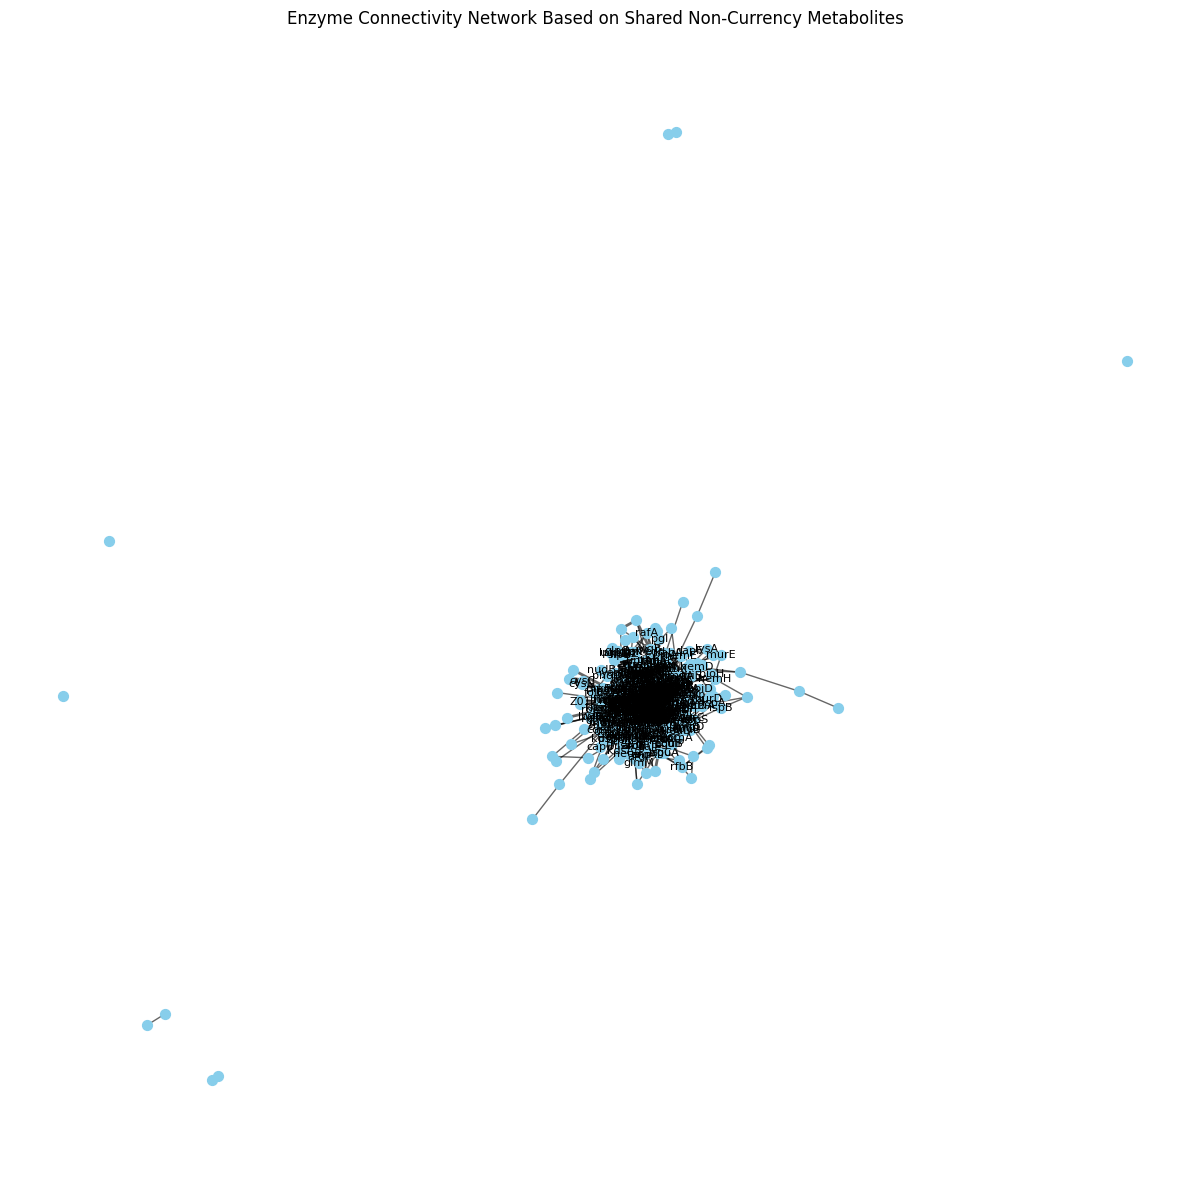

In [ ]:
# --------------------------------------------
# 1. Load the Genome-Scale Model from JSON
# --------------------------------------------
#model = cobra.io.load_json_model("genome_scale_model.json")
print("Model loaded.")
print(f"Number of reactions: {len(model.reactions)}")
print(f"Number of metabolites: {len(model.metabolites)}")
print(f"Number of genes: {len(model.genes)}")

# --------------------------------------------
# 2. Define Currency Metabolites
# --------------------------------------------
# This is a manually curated set of ModelSEED compound IDs that are considered currency metabolites.
# Adjust this set as needed. For example:
currency_metabolites = {
    "cpd00001",  # H2O
    "cpd00002",  # ATP
    "cpd00008",  # ADP
    "cpd00009",  # AMP
    "cpd00011",  # Pi
    "cpd00012",  # PPi
    "cpd00067",  # NAD
    "cpd00068",  # NADH
    "cpd00013",  # (example, adjust if needed)
    # Add others as appropriate...
}

# --------------------------------------------
# 3. Build a Dictionary Mapping Genes to Non-Currency Metabolites
# --------------------------------------------
# Here, we assume that enzymes are represented as genes in the model.
# For each gene, we collect all metabolites from the reactions in which it participates,
# then filter out any metabolite whose base ID (ignoring compartment suffix) is a currency metabolite.
gene_to_metabolites = {}

for gene in model.genes:
    metabolites_set = set()
    # gene.reactions is the set of reactions in which the gene is involved.
    for rxn in gene.reactions:
        for met in rxn.metabolites:
            # Assume metabolite IDs are like "cpdXXXXX_c". We split on '_' to get the base ID.
            base_id = met.id.split("_")[0]
            if base_id not in currency_metabolites:
                metabolites_set.add(met.id)  # You can choose to keep the compartment if desired.
    gene_to_metabolites[gene.id] = metabolites_set

# --------------------------------------------
# 4. Build the Enzyme Connectivity Network
# --------------------------------------------
# Create an undirected graph where each node is a gene.
G = nx.Graph()

# Add all genes as nodes.
for gene in gene_to_metabolites:
    G.add_node(gene)

# Add edges: Two genes are connected if they share at least one non-currency metabolite.
genes = list(gene_to_metabolites.keys())
for i in range(len(genes)):
    for j in range(i + 1, len(genes)):
        gene1 = genes[i]
        gene2 = genes[j]
        shared = gene_to_metabolites[gene1].intersection(gene_to_metabolites[gene2])
        if shared:
            # Optionally, use the number of shared metabolites as edge weight.
            G.add_edge(gene1, gene2, weight=len(shared), shared_metabolites=shared)

print("\n--- Network Statistics ---")
print(f"Number of nodes (enzymes): {G.number_of_nodes()}")
print(f"Number of edges (connections): {G.number_of_edges()}")

# --------------------------------------------
# 5. Visualize the Network
# --------------------------------------------
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Use a fixed seed for reproducibility

# Draw nodes; for larger networks, you might want to adjust the node size.
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')

# Draw edges with widths proportional to the number of shared metabolites.
edges = G.edges(data=True)
edge_widths = [d.get('weight', 1) for (_, _, d) in edges]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)

# Optionally, draw labels for a subset of nodes.
# For clarity, we only label nodes with a degree above a threshold.
high_degree_nodes = {n: n for n, d in G.degree() if d > 3}
nx.draw_networkx_labels(G, pos, labels=high_degree_nodes, font_size=8)

plt.title("Enzyme Connectivity Network Based on Shared Non-Currency Metabolites")
plt.axis("off")
plt.tight_layout()
plt.show()


Total connected components: 7
Largest connected component has 557 nodes.


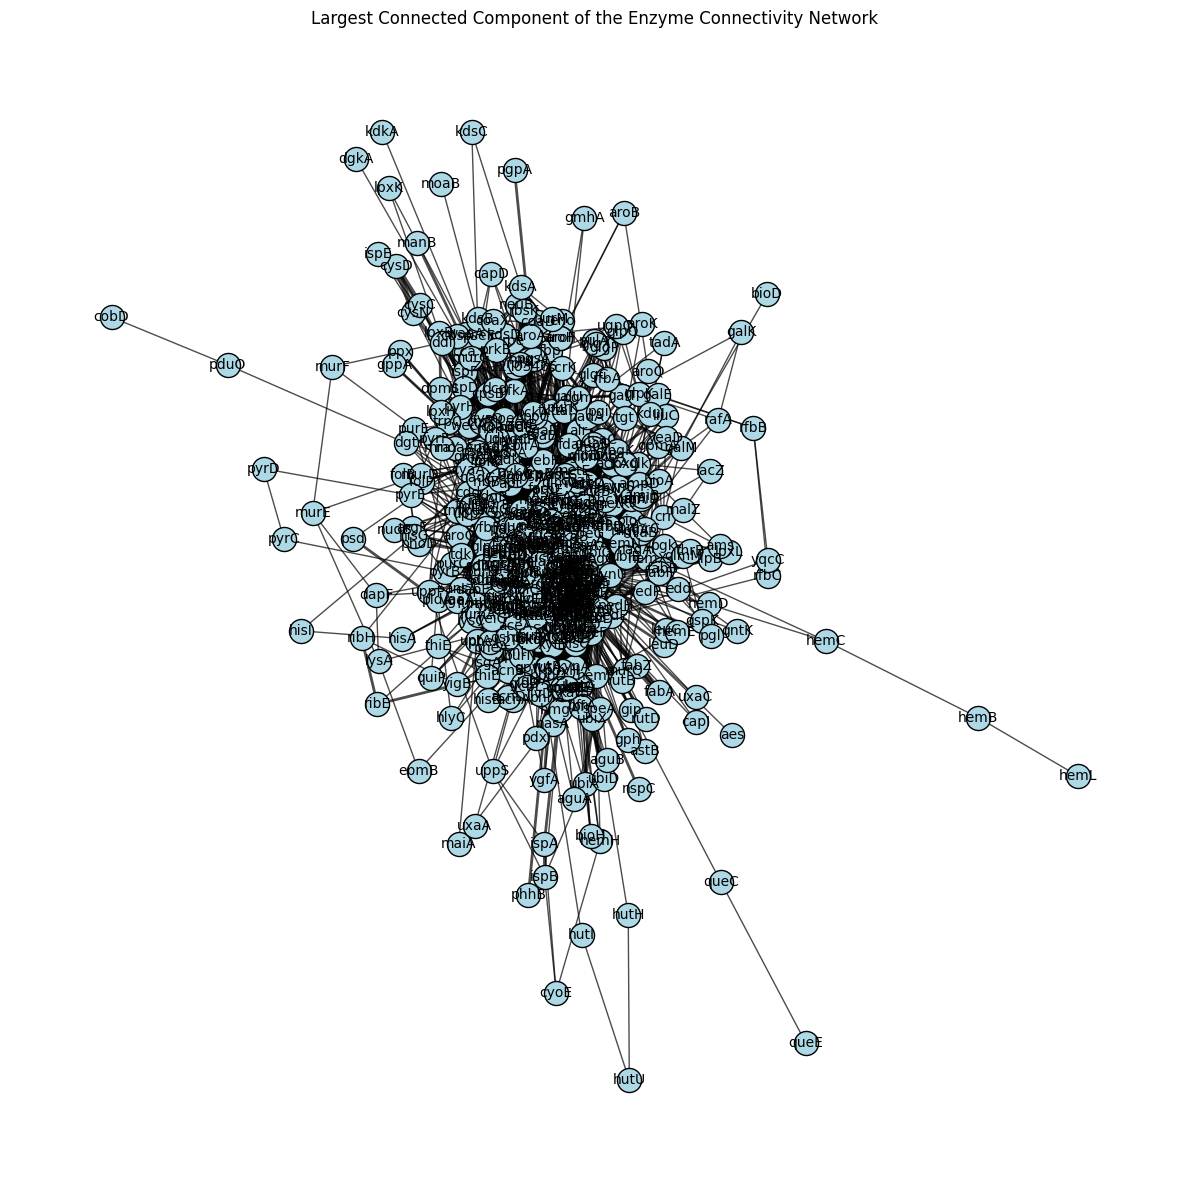

In [ ]:
# --------------------------------------------
# 1. Extract the Largest Connected Component
# --------------------------------------------

# Get the connected components as subgraphs
connected_components = list(nx.connected_components(G))
print(f"Total connected components: {len(connected_components)}")

# Identify the largest component (by number of nodes)
largest_cc = max(connected_components, key=len)
print(f"Largest connected component has {len(largest_cc)} nodes.")

# Create a subgraph of G containing only the largest connected component
G_largest = G.subgraph(largest_cc).copy()

# --------------------------------------------
# 2. Visualize the Largest Connected Component
# --------------------------------------------

plt.figure(figsize=(12, 12))

# Use a spring layout for the subgraph
pos = nx.spring_layout(G_largest, seed=42)

# Draw nodes with a larger size for better readability
nx.draw_networkx_nodes(G_largest, pos, node_size=300, node_color='lightblue', edgecolors='black')

# Draw edges with widths proportional to the number of shared metabolites
edge_widths = [d.get('weight', 1) for (_, _, d) in G_largest.edges(data=True)]
nx.draw_networkx_edges(G_largest, pos, width=edge_widths, alpha=0.7)

# Draw labels for all nodes
nx.draw_networkx_labels(G_largest, pos, font_size=10, font_family="sans-serif")

plt.title("Largest Connected Component of the Enzyme Connectivity Network")
plt.axis("off")
plt.tight_layout()
plt.show()
